In [1]:
%load_ext autoreload
%aimport utils
%autoreload 1


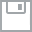
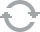
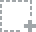
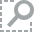
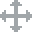
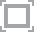
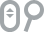
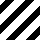
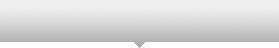
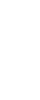
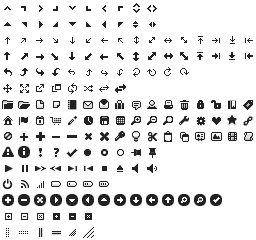
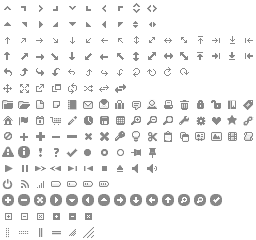
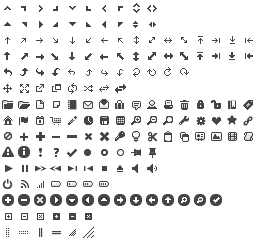
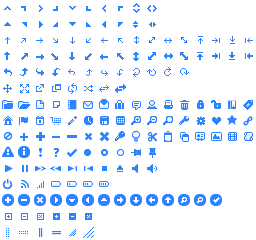
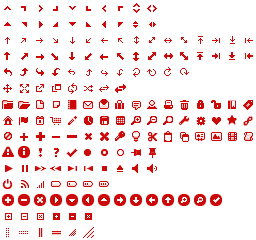
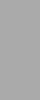
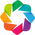
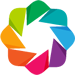

In [2]:
import statsmodels.api as sm
import pandas as pd
pd.options.display.max_rows=10
import numpy as np

from bokeh.io import output_notebook, show 
from bokeh.plotting import figure
from  bokeh.mpl import to_bokeh
output_notebook()
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(6,4)

In [3]:
train=utils.load_train()

store大部份沒有trend。   
store1的promo變化太小。   
選store6，有下降的trend。
store55有中間暫時下降回升的trend。

In [23]:
y=train[train.Store==6].set_index('Date')[['Sales']].asfreq('D')
X=train[train.Store==6].set_index('Date').asfreq('D')
y.shape[0]==942  # 942 = no missing 

True

# decompose
seasonal component 使用14天的promo週期抽取失敗因為並非都是14天，需要改成 抽取by exact promo time.


In [5]:
# res = sm.tsa.seasonal_decompose(y.values,freq=14) # 處理date部分有bug，轉np array

# f,ax=plt.subplots(4,1)
# f.set_size_inches(12,3)
# ax[0].plot( res.observed)
# ax[1].plot( res.seasonal)
# ax[2].plot( res.trend)
# ax[3].plot( res.resid)
# show(to_bokeh())

# data exploration for modeling ARMA

In [6]:
ts=pd.DataFrame(y)

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


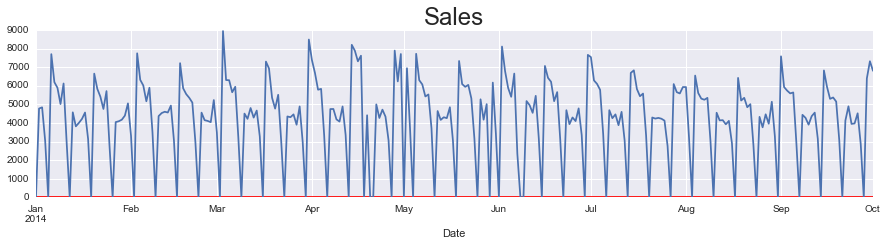

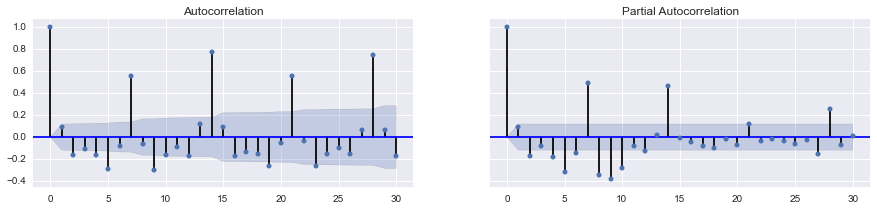

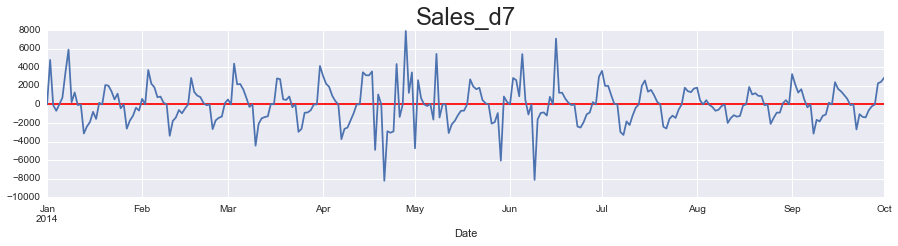

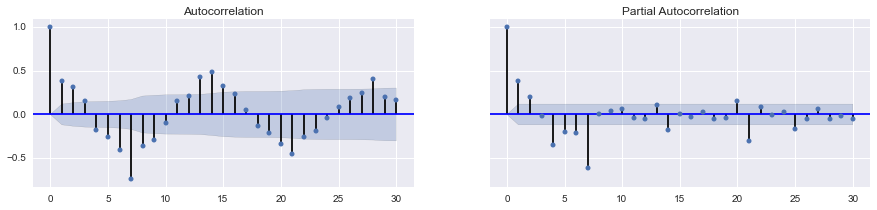

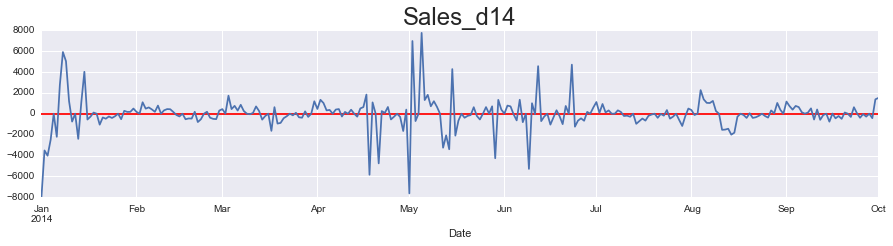

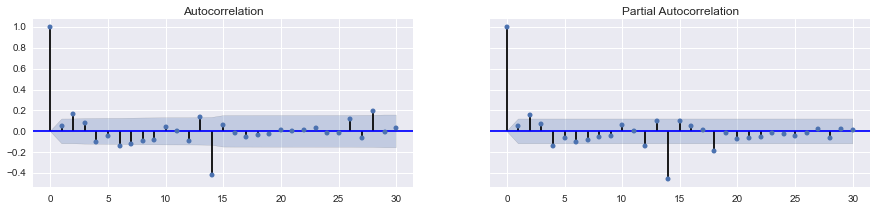

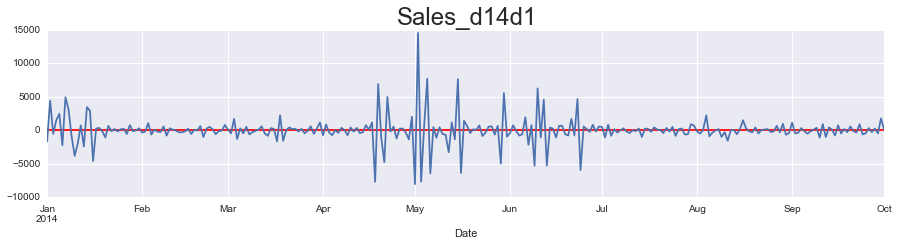

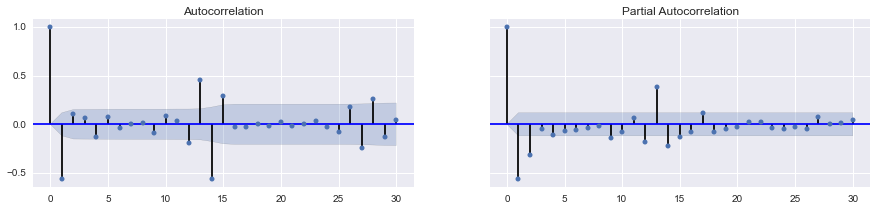

In [7]:
# ts['ln_Sales'] = np.log(ts.Sales+100)
ts['Sales_d7'] = ts.Sales.diff(7)
# ts['Sales_d7d14'] = ts.Sales.diff(7).diff(14)
ts['Sales_d14'] = ts.Sales.diff(14)
ts['Sales_d14d1'] = ts.Sales.diff(14).diff(1)
# Graph data
for x in [ts.Sales,ts.Sales_d7,ts.Sales_d14,ts.Sales_d14d1]:
    x=x['2014-01-01':'2014-10-01']
    fig, axes = plt.subplots(1, 1, figsize=(15,3))
    ax=x.plot(ax=axes)
    ax.hlines(0, ts.index[0], ts.index[-1], 'r')
    ax.set_title(x.name)
    ax.title.set_fontsize(24)
    
    fig, axes = plt.subplots(1, 2, figsize=(15,3),sharex=True,sharey=True)
    sm.graphics.tsa.plot_acf(x, lags=30,ax=axes[0]);
    sm.graphics.tsa.plot_pacf(x, lags=30, ax=axes[1]);

# show(to_bokeh())

# ARIMA

In [8]:
SARIMAX = sm.tsa.statespace.SARIMAX

Date
2013-01-01    0
2013-01-02    0
2013-01-03    0
2013-01-04    0
2013-01-05    0
             ..
2015-07-27    0
2015-07-28    0
2015-07-29    0
2015-07-30    0
2015-07-31    0
Freq: D, Name: StateHoliday, dtype: object

In [ ]:
X.index.mon

In [131]:
_X=X[['Open','Promo','SchoolHoliday']]
_X['StateHoliday']=X.StateHoliday.astype(str).replace(['a', 'b', 'c'],'0').astype(np.float)
_X['Month']=X.index.month
_X['WeekDay']=X.index.weekday
_X['time']=(X.index-X.index.min()).days
_X['const']=1
_X

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,Open,Promo,SchoolHoliday,StateHoliday,Month,WeekDay,time,const
Date,,,,,,,,
2013-01-01,0,0,1,0,1,1,0,1
2013-01-02,1,0,1,0,1,2,1,1
2013-01-03,1,0,0,0,1,3,2,1
2013-01-04,1,0,0,0,1,4,3,1
2013-01-05,1,0,0,0,1,5,4,1
...,...,...,...,...,...,...,...,...
2015-07-27,1,1,1,0,7,0,937,1
2015-07-28,1,1,1,0,7,1,938,1
2015-07-29,1,1,1,0,7,2,939,1


In [140]:
arma = SARIMAX(ts.Sales, exog=_X, trend=None, order=(3,0,0),seasonal_order=(2,1,1,14))
%time arma = arma.fit()
print(arma.summary())

CPU times: user 1min 12s, sys: 2.58 s, total: 1min 15s
Wall time: 1min 16s
                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  942
Model:             SARIMAX(3, 0, 0)x(2, 1, 1, 14)   Log Likelihood               -7362.491
Date:                            Sat, 02 Jan 2016   AIC                          14754.982
Time:                                    20:07:39   BIC                          14827.702
Sample:                                01-01-2013   HQIC                         14782.700
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open           5423.1334     85.7

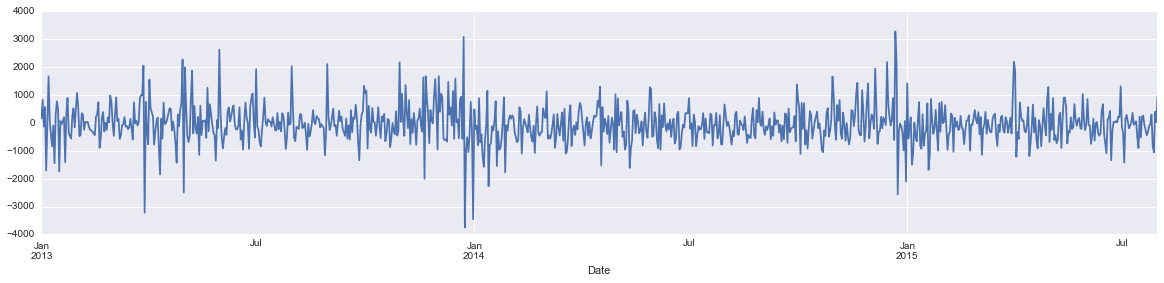

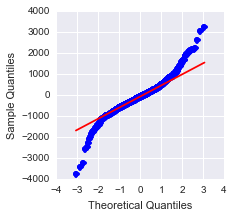

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


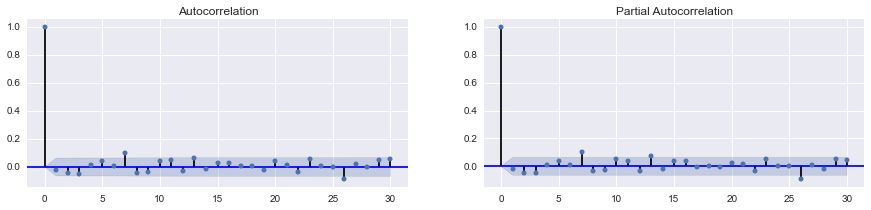

In [109]:
resid=arma.resid
ax=resid.plot()
ax.figure.set_size_inches(20,4)
f=sm.qqplot(resid,line='q')
f.set_size_inches(3,3)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,3))
sm.graphics.tsa.plot_acf(resid, lags=30,ax=ax1);
sm.graphics.tsa.plot_pacf(resid, lags=30, ax=ax2);

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/data.py:551: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(squeezed, index=self.predict_dates)


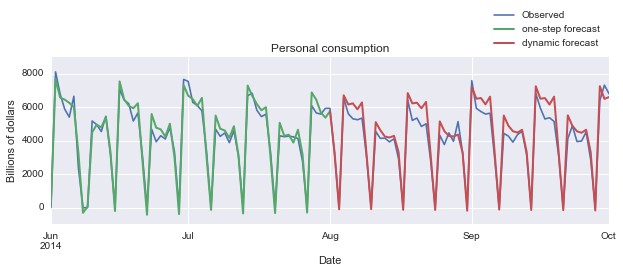

In [160]:
# Dynamic predictions
pred_start='2014-08-01'
predict_dy = arma.get_prediction(dynamic=pred_start)
predict_dy_ci = predict_dy.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(10,3))
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

t_start='2014-06-01'
t_end='2014-10-01'
# Plot data points
ts.Sales.ix[t_start:t_end].plot(ax=ax, style='-',linewidth=1.6, label='Observed')
# Plot predictions
# predict.predicted_mean.ix['1977-07-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
# ci = predict_ci.ix['1977-07-01':]
# ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.ix[t_start:pred_start].plot(ax=ax,style='-',linewidth=2, label='one-step forecast')
predict_dy.predicted_mean.ix[pred_start:t_end].plot(ax=ax,style='-', linewidth=2,label='dynamic forecast')
# ci = predict_dy_ci.ix['1977-07-01':]
# ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right',bbox_to_anchor=(1,1))

In [137]:
%%time
# (3,0,0,2,1,1,14)
# (3,0,0,3,2,1,14)
s=[7,14]
Q=[0,1]
D=[0,1]
P=[1,2]
q=[0,1]
d=[0,1]
p=[2,3]

import itertools
orders=list(itertools.product(p,d,q,P,D,Q,s))
counter=len(orders)
res={}
for (p,d,q,P,D,Q,s) in orders:
    arma = SARIMAX(ts.Sales,exog=_X, trend=None, order=(p,d,q),seasonal_order=(P,D,Q,s))
    try:
        arma = arma.fit(method='lbfgs',maxiter=50)
        res[(p,d,q,P,D,Q,s)]=(arma.aic,arma.bic)
        counter-=1
        print('finish {}, {} remains'.format((p,d,q,P,D,Q,s),counter))
    except:
        print('order {} fail'.format((p,d,q,P,D,Q,s)))
    

finish (2, 0, 0, 1, 0, 0, 7), 127 remains
finish (2, 0, 0, 1, 0, 0, 14), 126 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 0, 0, 1, 0, 1, 7), 125 remains
finish (2, 0, 0, 1, 0, 1, 14), 124 remains
finish (2, 0, 0, 1, 1, 0, 7), 123 remains
finish (2, 0, 0, 1, 1, 0, 14), 122 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 0, 0, 1, 1, 1, 7), 121 remains
finish (2, 0, 0, 1, 1, 1, 14), 120 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 0, 0, 2, 0, 0, 7), 119 remains
finish (2, 0, 0, 2, 0, 0, 14), 118 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 0, 0, 2, 0, 1, 7), 117 remains
finish (2, 0, 0, 2, 0, 1, 14), 116 remains
finish (2, 0, 0, 2, 1, 0, 7), 115 remains
finish (2, 0, 0, 2, 1, 0, 14), 114 remains
finish (2, 0, 0, 2, 1, 1, 7), 113 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 0, 0, 2, 1, 1, 14), 112 remains
order (2, 0, 1, 1, 0, 0, 7) fail
order (2, 0, 1, 1, 0, 0, 14) fail
order (2, 0, 1, 1, 0, 1, 7) fail
order (2, 0, 1, 1, 0, 1, 14) fail
finish (2, 0, 1, 1, 1, 0, 7), 111 remains
finish (2, 0, 1, 1, 1, 0, 14), 110 remains
finish (2, 0, 1, 1, 1, 1, 7), 109 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 0, 1, 1, 1, 1, 14), 108 remains
order (2, 0, 1, 2, 0, 0, 7) fail
order (2, 0, 1, 2, 0, 0, 14) fail
order (2, 0, 1, 2, 0, 1, 7) fail
order (2, 0, 1, 2, 0, 1, 14) fail
finish (2, 0, 1, 2, 1, 0, 7), 107 remains
finish (2, 0, 1, 2, 1, 0, 14), 106 remains
finish (2, 0, 1, 2, 1, 1, 7), 105 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 0, 1, 2, 1, 1, 14), 104 remains
finish (2, 1, 0, 1, 0, 0, 7), 103 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 0, 1, 0, 0, 14), 102 remains
finish (2, 1, 0, 1, 0, 1, 7), 101 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 0, 1, 0, 1, 14), 100 remains
finish (2, 1, 0, 1, 1, 0, 7), 99 remains
finish (2, 1, 0, 1, 1, 0, 14), 98 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 0, 1, 1, 1, 7), 97 remains
finish (2, 1, 0, 1, 1, 1, 14), 96 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 0, 2, 0, 0, 7), 95 remains
finish (2, 1, 0, 2, 0, 0, 14), 94 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 0, 2, 0, 1, 7), 93 remains
finish (2, 1, 0, 2, 0, 1, 14), 92 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 0, 2, 1, 0, 7), 91 remains
finish (2, 1, 0, 2, 1, 0, 14), 90 remains
finish (2, 1, 0, 2, 1, 1, 7), 89 remains
finish (2, 1, 0, 2, 1, 1, 14), 88 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 1, 1, 0, 0, 7), 87 remains
finish (2, 1, 1, 1, 0, 0, 14), 86 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 1, 1, 0, 1, 7), 85 remains
finish (2, 1, 1, 1, 0, 1, 14), 84 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 1, 1, 1, 0, 7), 83 remains
finish (2, 1, 1, 1, 1, 0, 14), 82 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 1, 1, 1, 1, 7), 81 remains
finish (2, 1, 1, 1, 1, 1, 14), 80 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 1, 2, 0, 0, 7), 79 remains
finish (2, 1, 1, 2, 0, 0, 14), 78 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 1, 2, 0, 1, 7), 77 remains
finish (2, 1, 1, 2, 0, 1, 14), 76 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 1, 2, 1, 0, 7), 75 remains
finish (2, 1, 1, 2, 1, 0, 14), 74 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (2, 1, 1, 2, 1, 1, 7), 73 remains
finish (2, 1, 1, 2, 1, 1, 14), 72 remains
finish (3, 0, 0, 1, 0, 0, 7), 71 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 0, 1, 0, 0, 14), 70 remains
finish (3, 0, 0, 1, 0, 1, 7), 69 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 0, 1, 0, 1, 14), 68 remains
finish (3, 0, 0, 1, 1, 0, 7), 67 remains
finish (3, 0, 0, 1, 1, 0, 14), 66 remains
finish (3, 0, 0, 1, 1, 1, 7), 65 remains
finish (3, 0, 0, 1, 1, 1, 14), 64 remains
finish (3, 0, 0, 2, 0, 0, 7), 63 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 0, 2, 0, 0, 14), 62 remains
finish (3, 0, 0, 2, 0, 1, 7), 61 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 0, 2, 0, 1, 14), 60 remains
finish (3, 0, 0, 2, 1, 0, 7), 59 remains
finish (3, 0, 0, 2, 1, 0, 14), 58 remains
finish (3, 0, 0, 2, 1, 1, 7), 57 remains
finish (3, 0, 0, 2, 1, 1, 14), 56 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 1, 1, 0, 0, 7), 55 remains
finish (3, 0, 1, 1, 0, 0, 14), 54 remains
finish (3, 0, 1, 1, 0, 1, 7), 53 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 1, 1, 0, 1, 14), 52 remains
finish (3, 0, 1, 1, 1, 0, 7), 51 remains
finish (3, 0, 1, 1, 1, 0, 14), 50 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 1, 1, 1, 1, 7), 49 remains
finish (3, 0, 1, 1, 1, 1, 14), 48 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 1, 2, 0, 0, 7), 47 remains
finish (3, 0, 1, 2, 0, 0, 14), 46 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 1, 2, 0, 1, 7), 45 remains
finish (3, 0, 1, 2, 0, 1, 14), 44 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 1, 2, 1, 0, 7), 43 remains
finish (3, 0, 1, 2, 1, 0, 14), 42 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 0, 1, 2, 1, 1, 7), 41 remains
finish (3, 0, 1, 2, 1, 1, 14), 40 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 0, 1, 0, 0, 7), 39 remains
finish (3, 1, 0, 1, 0, 0, 14), 38 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 0, 1, 0, 1, 7), 37 remains
finish (3, 1, 0, 1, 0, 1, 14), 36 remains
finish (3, 1, 0, 1, 1, 0, 7), 35 remains
finish (3, 1, 0, 1, 1, 0, 14), 34 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 0, 1, 1, 1, 7), 33 remains
finish (3, 1, 0, 1, 1, 1, 14), 32 remains
finish (3, 1, 0, 2, 0, 0, 7), 31 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 0, 2, 0, 0, 14), 30 remains
finish (3, 1, 0, 2, 0, 1, 7), 29 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 0, 2, 0, 1, 14), 28 remains
finish (3, 1, 0, 2, 1, 0, 7), 27 remains
finish (3, 1, 0, 2, 1, 0, 14), 26 remains
finish (3, 1, 0, 2, 1, 1, 7), 25 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 0, 2, 1, 1, 14), 24 remains
finish (3, 1, 1, 1, 0, 0, 7), 23 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 1, 1, 0, 0, 14), 22 remains
finish (3, 1, 1, 1, 0, 1, 7), 21 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 1, 1, 0, 1, 14), 20 remains
finish (3, 1, 1, 1, 1, 0, 7), 19 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 1, 1, 1, 0, 14), 18 remains
finish (3, 1, 1, 1, 1, 1, 7), 17 remains
finish (3, 1, 1, 1, 1, 1, 14), 16 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 1, 2, 0, 0, 7), 15 remains
finish (3, 1, 1, 2, 0, 0, 14), 14 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 1, 2, 0, 1, 7), 13 remains
finish (3, 1, 1, 2, 0, 1, 14), 12 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 1, 2, 1, 0, 7), 11 remains
finish (3, 1, 1, 2, 1, 0, 14), 10 remains

/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



finish (3, 1, 1, 2, 1, 1, 7), 9 remains
finish (3, 1, 1, 2, 1, 1, 14), 8 remains
CPU times: user 56min 53s, sys: 55.5 s, total: 57min 49s
Wall time: 57min 11s


/Users/apple/miniconda3/envs/sm0.7_dev/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


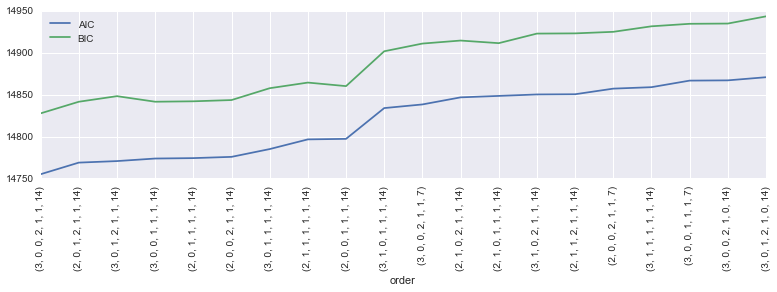

In [138]:
df=pd.DataFrame([ (k, v[0],v[1]) for k,v in res.items()],columns=['order','AIC','BIC'])
df=df.sort('AIC').set_index('order')
n=20
ax=df[:n].plot(rot=90)
ax.set_xticks(range(n))
ax.set_xticklabels(df[:n].index.values);
ax.figure.set_size_inches(13,3)

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.])

In [ ]:

# ts is a time series
logged_ts = np.log(ts)
# Differencing by the week forces us to drop the first 7 values.
diffed_logged_ts = (logged_ts - logged_ts.shift(7))[7:]

p = 0
d = 1
q = 1

arima = ARIMA(diffed_logged_ts.values, [p, d, q],
              exog=None, dates=diffed_logged_ts.index, freq='D', missing='none')

arima = arima.fit(trend='c', disp=False)
pred = arima.predict(exog=None, dynamic=False)
pred = pd.Series(pred, index=diffed_logged_ts.index[d:])
pred = np.exp(logged_ts.shift(7) + diffed_logged_ts.shift(d) + pred)

concatenated = pd.concat([ts, pred], axis=1, keys=['original', 'predicted'])
print concatenated[-7:]